In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_PATH'] = '/usr/local/cuda-10.0'

import transformers
import datasets

import torch
from pathlib import Path
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          TrainingArguments, Trainer)

import numpy as np
import re
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
form = 'red2'
label_len = 20

In [3]:
test_enc_1 = load_dataset('json', data_files=f'data/{form}/testenc-{label_len}.json', split='train[:50%]')
test_enc_2 = load_dataset('json', data_files=f'data/{form}/testenc-{label_len}.json', split='train[50%:]')
val_enc = load_dataset('json', data_files=f'data/{form}/valenc-{label_len}.json', split='train')
train_enc = load_dataset('json', data_files=f'data/{form}/train-citationcleaned-{label_len}.json', split='train')

Using custom data configuration default-d9ecd716484d21f3


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-d9ecd716484d21f3


Dataset json downloaded and prepared to /home/14cfl/.cache/huggingface/datasets/json/default-d9ecd716484d21f3/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


Reusing dataset json (/home/14cfl/.cache/huggingface/datasets/json/default-d9ecd716484d21f3/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)
Using custom data configuration default-f0e098c8b2d88652


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /home/14cfl/.cache/huggingface/datasets/json/default-f0e098c8b2d88652/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


Using custom data configuration default-1a49b4eb58afb15c


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /home/14cfl/.cache/huggingface/datasets/json/default-1a49b4eb58afb15c/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


In [5]:

model_ckpt = 'baseline/baseline-512-20-nlpaueb/legal-bert-base-uncased/checkpoint-34000/'

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_and_encode_in(examples):
    return tokenizer(examples['input'], max_length=512, truncation=True, padding=True)

cols = train_enc.column_names
print(cols)
cols.remove("labels")
train_enc = train_enc.map(tokenize_and_encode_in, batched=True, remove_columns=cols)

['files', 'labels', 'input', 'original', 'codes']


  0%|          | 0/142 [00:00<?, ?ba/s]

In [6]:
from transformers import AutoModel,AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torchinfo import summary
device = 'cuda'
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt).to(device)

#out = model(sample, )
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           15,380
Total params: 1

In [7]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
import umap

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

dim_reduc = umap.UMAP(random_state=10, metric='euclidean')

def plot_umap(normalized_df, colour, name, prototypes=None, definitions=None):
    standard_embedding = dim_reduc.fit_transform(normalized_df)
    plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=colour, cmap='YlGnBu', s=1)
    
    if prototypes is not None:
        prot_embedding = dim_reduc.transform(prototypes)

        plt.scatter(prot_embedding[:, 0], prot_embedding[:, 1], color='r', s=5)
    
    if definitions is not None:
        def_embedding = dim_reduc.transform(definitions)
        plt.scatter(def_embedding[:, 0], def_embedding[:, 1], color='m', s=5)
    
    plt.savefig(name, dpi=200, bb_inches='tight')
    plt.show()

def plot_tsne(normalized_df, colour):
    standard_embedding = TSNE(n_components=2, perplexity=8, learning_rate='auto',init='random').fit_transform(normalized_df)
    plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=colour, s=1, cmap='bwr')


/home/14cfl/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [9]:
dl = torch.utils.data.DataLoader(train_enc, batch_size=8)

In [10]:
# print(model.num_labels, model.device)
device = model.device
#if state.epoch >= 6 and state.epoch % 5 == 0:
model.eval()
x = []
samples = [[] for i in range(label_len)]
# p_per_class = int(/label_len)

label = []

with torch.no_grad():
    for data in tqdm(dl, desc="obtaining hidden states"):
        # encoding data to hidden state - dim should be (N, D) - N batch size, D hidden vector dim
        inp = torch.t(torch.stack(data['input_ids']))
        mask = torch.t(torch.stack(data['attention_mask']))
#         print(inp[:,:512].shape, mask.shape)
        labels = torch.t(torch.stack(data.pop("labels")))
        outputs = model(input_ids=inp.to(device), attention_mask=mask.to(device))
#         print(dir(outputs))
        logits = outputs.logits.cpu()
        #print(logits.shape)
        # reversing one-hot encoding of the labels
        labs = (labels == 1).nonzero()

        #print(labs)
        labels = {}
        for l in labs:
            if l[0].item() in labels:
                labels[l[0].item()].append(l[1].item())
            else:
                labels[l[0].item()] = [l[1].item()]
        #print(labels)
        # adding each hidden state to its respective class' list
        for k, v in labels.items():
            for c in v:
                #print(c)
                x.append(logits[k, :])
                label.append(c)
                samples[c].append(inp[k,:])
    print('plotting data points')
    #print([len(x) for x in x_per_class])
#     # projecting prototypes for each class
#     print('prototypes:')
#     for i in range(model.prototype_sample.data.size(0)):
#         for j in range(model.prototype_sample.data.size(1)):
#             with open(f'prototypes-red2-20-defs/_{i}_{j}.txt', 'w') as f:
#                 text = tokenizer.decode(model.prototype_sample.data[i,j,:].int())
#                 print(text)
#                 f.write(text)

    x = np.stack(x)
    labels = np.stack(label)
    
# #     prots = model.prototype_vectors.cpu()
#     defs = model.roberta(model.definition_tokens).last_hidden_state[:,0,:].cpu()


obtaining hidden states:   0%|          | 0/17655 [00:00<?, ?it/s]

plotting data points


/home/14cfl/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bb_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


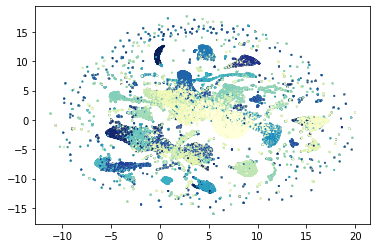

In [11]:

plot_umap(x, labels, 'legalbert-finetuned-20.pdf')